In [1]:
import os
import sys
import time
import datetime

import numpy as np
import pandas as pd
import collections
import scipy
import scipy.io
import scipy.stats
import mat73

import matplotlib.pyplot as plt
import seaborn as sns
from skimage import data, img_as_float
from numpy import linalg as LA
from pandas import Series
import pandas.core.algorithms as algos

from sklearn.preprocessing import (
    MultiLabelBinarizer, LabelBinarizer, LabelEncoder, 
    StandardScaler, MinMaxScaler, OneHotEncoder
)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix, precision_recall_fscore_support, 
    roc_auc_score, mean_squared_error, mean_absolute_error, 
    median_absolute_error, r2_score
)

import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras import layers, initializers, backend as K, regularizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.layers import (
    Embedding, Dense, Dropout, Reshape, BatchNormalization, 
    TimeDistributed, Lambda, Activation, LSTM, GRU, Flatten, 
    Convolution1D, MaxPooling1D, concatenate, Conv2D, 
    MaxPooling2D, Conv3D, MaxPooling3D, dot, Permute, 
    Concatenate, add, LeakyReLU
)
from keras_tuner import BayesianOptimization
import hosvd
from scipy.io import loadmat, savemat

#os.environ['CUDA_VISIBLE_DEVICES'] = ''


In [2]:

################################################################################
# Auxiliary functions
################################################################################

def perform_hosvd(tensor, tolerance):
    #
    ##  Configuration (that do not depend on the user):
    #
    SNAP = tensor.shape[-1]

    TimePos = tensor.ndim

    Tensor0 = tensor.copy()
    shapeTens = list(np.shape(tensor))
    shapeTens[-1] = SNAP
    Tensor = np.zeros(shapeTens)

    Tensor[..., :] = Tensor0[..., 0:SNAP]

    nn0 = np.array(Tensor.shape)
    nn = np.array(nn0)
    nn[1:np.size(nn)] = 0

    #
    ##  Perform HOSVD on input data set using the tolerance specified:
    #
    return hosvd.HOSVD(Tensor, tolerance, nn, nn0, TimePos)




In [3]:
file_type = input("Enter file type (.npy or .mat): ").strip()

file_path = input("Enter the file path: ").strip()

# Load the tensor dataset based on file type
if file_type == '.npy':
    tensorOrig1 = np.load(file_path)
elif file_type == '.mat':
    tensorOrig1 = mat73.loadmat(file_path)['Tensor']
else:
    raise ValueError("Unsupported file type. Please provide a .npy or .mat file.")

print(f"Original Tensor shape: {tensorOrig1.shape}")

print(f"Original Tensor shape: {tensorOrig1.shape}")

total_slices = tensorOrig1.shape[-1]
print(f"The dataset contains {total_slices} temporal snapshots.")
temporal_range = input(
    f"Enter the range of temporal snapshots to consider (e.g., '100-200' or '300-{total_slices}'): "
).strip()

try:
    start, end = map(int, temporal_range.split('-'))
    if start < 1 or end > total_slices or start > end:
        raise ValueError
except ValueError:
    raise ValueError(f"Invalid range. Please specify a valid range between 1 and {total_slices}.")

# Slice the tensor based on the provided range
tensorOrig = tensorOrig1[..., start - 1:end] 

Enter file type (.npy or .mat):  .npy
Enter the file path:  Re130_u.npy


Original Tensor shape: (2, 100, 100, 500)
Original Tensor shape: (2, 100, 100, 500)
The dataset contains 500 temporal snapshots.


Enter the range of temporal snapshots to consider (e.g., '100-200' or '300-500'):  1-500


In [5]:
tensor_main = tensorOrig

# Set the splitting ratios: 80% training, 20% validation
total_snapshots = tensor_main.shape[-1]
train_slices = int(total_snapshots * 0.8)
val_slices = total_snapshots - train_slices

# Define the desired tensor dimensions for HOSVD.
tensor_dims = list(tensor_main.shape[:-1])
default_num_modes = max(1, int(0.2 * tensor_main.shape[-1]))  # Default: 20% of total modes. Adjust according to requirement
num_modes_input = input(f'Please enter the number of modes to use for HOSVD [Default {default_num_modes}]: ')
num_modes = int(num_modes_input) if num_modes_input else default_num_modes
tensor_dims.append(num_modes)  

TT, S_main, U_main, sv_main, n_main = hosvd.HOSVD_function(tensor_main, tensor_dims)
tensor_train = tensor_main[..., :train_slices]
tensor_val = tensor_main[..., train_slices:]

#### Change and restrict the values as required
S_train = S_main   
sv_train = sv_main
n_train = n_main

S_val = S_main     
sv_val = sv_main
n_val = n_main
U_train = U_main
U_val = U_main

print(f"Training Tensor shape: {tensor_train.shape}")
print(f"Validation Tensor shape: {tensor_val.shape}")

del TT

Please enter the number of modes to use for HOSVD [Default 100]:  10


Training Tensor shape: (2, 100, 100, 400)
Validation Tensor shape: (2, 100, 100, 100)


In [30]:
tensor_modes = tensor_train.ndim    
temporal_mode = tensor_modes - 1      

U_temp = U_main[0, temporal_mode]  
sv_temp = sv_main[0, temporal_mode]  

# Training: first 80% snapshots; Validation: last 20%
U_train_temp = U_temp[:train_slices, :]  
U_val_temp   = U_temp[train_slices:, :]   


AML_train = U_train_temp * sv_temp[None, :]  
AML_dev   = U_val_temp   * sv_temp[None, :]    


AML_train = AML_train.T  # shape becomes: (num_modes, train_slices)
AML_dev   = AML_dev.T    # shape becomes: (num_modes, val_slices)

print("Element-wise multiplication result for training set:", AML_train.shape)
print("Element-wise multiplication result for validation set:", AML_dev.shape)

tensor = np.concatenate([np.copy(AML_train), np.copy(AML_dev)], axis=1)
tensor_test = np.copy(AML_dev)

print("Shape of tensor_test:", tensor_test.shape)


Element-wise multiplication result for training set: (10, 400)
Element-wise multiplication result for validation set: (10, 100)
Shape of tensor_test: (10, 100)


In [31]:
mean_val = np.mean(tensor)
std_val = np.std(tensor)
print("Mean:", mean_val)
print("Standard Deviation:", std_val)

# Quantiles of data
np.quantile(tensor.flatten(), np.arange(0,1,0.1))

# Z-Score Normalization (Standard Scaling)
tensor_norm = (tensor - mean_val) / std_val
tensor_train_norm = tensor_norm
tensor_test_norm = (tensor_test - mean_val) / std_val
tensor_val_norm = tensor_test_norm

scipy.stats.describe(tensor_norm.flatten())


total_length = tensor_norm.shape[1]  
channels_n = 0                       
dim_x = tensor_norm.shape[0]         
dim_y = 0                            

print('total_length: ', total_length)
print('channels_n: ', channels_n)
print('dim_x: ', dim_x)
print('dim_y: ', dim_y)



Mean: 9.855543436011029
Standard Deviation: 29.923104229653905
total_length:  500
channels_n:  0
dim_x:  10
dim_y:  0


In [32]:
class SequenceGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, list_IDs, batch_size=5, seq_len=624, horizon=1, shuffle=True, till_end=False, only_test=False):
        self.data = data
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.horizon = horizon
        self.till_end = till_end
        self.only_test = only_test
        self.on_epoch_end()

    def __len__(self):
        if self.till_end:
            return math.ceil(len(self.list_IDs) / self.batch_size)
        else:
            return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(list_IDs_temp)
        if self.only_test:
            return X
        else:
            return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        X = np.empty((self.batch_size, self.seq_len, self.data.shape[0]))
        y_inter = np.empty((self.batch_size, self.horizon, self.data.shape[0]))

        for i, ID in enumerate(list_IDs_temp):
            X[i, :, :] = self.data[:, ID:ID + self.seq_len].T
            y_inter[i, :, :] = self.data[:, ID + self.seq_len:ID + self.seq_len + self.horizon].T

        y = [y_inter[:, h, :] for h in range(self.horizon)]
        return X, y
        y = [y_inter[:, h, :] for h in range(self.horizon)]
        return X, y
        y = [y_inter[:, :, j].reshape(self.batch_size, -1) for j in range(self.p)]
        return X.transpose((0, 2, 1)), y
        y = [y_inter[:, :, j].reshape(self.batch_size, -1) for j in range(self.p)]
        return X.transpose((0, 2, 1)), y


###### Two LSTM Architectures ########

In [33]:
# from tensorflow.keras.layers import Input, LSTM, Dense, LeakyReLU, Reshape
# from tensorflow.keras.models import Model
# from tensorflow.keras.initializers import HeNormal
# from tensorflow.keras.optimizers import Adam

# def create_model(in_shape, out_dim, horizon=1, shared_dim=128, alpha=0.01, learning_rate=0.001):
#     x = Input(shape=in_shape)

#     # LSTM layer
#     v = LSTM(128, return_sequences=False)(x)
#     w = Dense(64, activation=LeakyReLU(alpha=alpha))(v)

#     # Output layer without reshaping
#     v = Dense(out_dim, activation='linear')(w)

#     model = Model(inputs=x, outputs=v, name='Temporal_forecasting')
#     model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=learning_rate), metrics=['mae'])

#     return model


###### Actual values in the paper. Change and adjust as per requirement. ########

In [34]:
####### Values of the actual parameters, epochs etc. in the paper ########
def create_model(in_shape, out_dim, horizon=1, shared_dim=128, learning_rate=0.001):
    x = Input(shape=in_shape)

    # LSTM layer
    v = LSTM(128, return_sequences=False)(x)
    
    # Output layer without reshaping
    v = Dense(out_dim, activation='linear')(v)

    model = Model(inputs=x, outputs=v, name='Temporal_forecasting')
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=learning_rate), metrics=['mae'])

    return model


def run_bayesian_optimization(tensor_norm, tensor_test_norm, AML_dev, AML_train, dim_x):
    def build_model(hp):
        seq_len = hp.Int('seq_len', min_value=5, max_value=20, step=5)
        batch_size = hp.Int('batch_size', min_value=4, max_value=32, step=4)
        learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-3, sampling='log')
        
        in_shape = (seq_len, dim_x)
        out_dim = dim_x
        model = create_model(in_shape, out_dim, horizon=1, shared_dim=128,  learning_rate=learning_rate)
        return model

    tuner = BayesianOptimization(
        build_model,
        objective='val_loss',
        max_trials=10,
        directory='bayesian_optimizationnew',
        project_name='lstm_hyperopthorizonnew'
    )

    # Define data generators for training
    train_gen = SequenceGenerator(tensor_norm, np.arange(AML_train.shape[1]), batch_size=10, seq_len=50, horizon=1, shuffle=True)
    val_gen = SequenceGenerator(tensor_norm, np.arange(AML_dev.shape[1]), batch_size=10, seq_len=50, horizon=1, shuffle=False)

    tuner.search(train_gen, validation_data=val_gen, epochs=10)

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    return best_hps

best_hps = run_bayesian_optimization(tensor_norm, tensor_test_norm, AML_dev, AML_train, dim_x)
print(f"Best hyperparameters: seq_len={best_hps.get('seq_len')}, batch_size={best_hps.get('batch_size')}, learning_rate={best_hps.get('learning_rate')}")

Reloading Tuner from bayesian_optimizationnew\lstm_hyperopthorizonnew\tuner0.json
Best hyperparameters: seq_len=5, batch_size=4, learning_rate=0.001


In [35]:
test_length = AML_dev.shape[-1]
val_length  = AML_dev.shape[1]
train_length = AML_train.shape[1]
best_seq_len = best_hps.get('seq_len')
best_batch_size = best_hps.get('batch_size')

train_generator = SequenceGenerator(
    tensor_norm, np.arange(AML_train.shape[1]),
    batch_size=best_batch_size,seq_len=best_seq_len, horizon=1, shuffle=True
)

validation_generator = SequenceGenerator(
    tensor_norm, np.arange(AML_dev.shape[1]),
    batch_size=best_batch_size, seq_len=best_seq_len, horizon=1, shuffle=False
)

test_generator = SequenceGenerator(
    tensor_test_norm, np.arange(tensor_test_norm.shape[1]),
    batch_size=best_batch_size, seq_len=best_seq_len, horizon=1, only_test=True, shuffle=False
)

for batch in validation_generator:
    input_nn, target_nn = batch
    break

print(len(input_nn))
print(input_nn[0].shape)
print(len(target_nn))
print(target_nn[0].shape)

4
(5, 10)
1
(4, 10)


In [36]:
# Create and summarize the model
model = create_model(in_shape=(best_seq_len, dim_x), out_dim=dim_x, horizon=1,  learning_rate=best_hps.get('learning_rate'))
model.summary()

Model: "Temporal_forecasting"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 10)]           0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               71168     
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 72,458
Trainable params: 72,458
Non-trainable params: 0
_________________________________________________________________


In [37]:
# save the best weights
import sys

save_string = 'saved_weights'

# save the best weights
save_best_weights = save_string + '.h5'
save_summary_stats = save_string + '.csv'
save_last_weights = save_string + '_last_w.h5'
save_results_metrics = save_string + '_results_metrics.csv'


In [38]:
np.random.seed(247531338)
tf.random.set_seed(31722973)

In [39]:

callbacks = [
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='auto'),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
]

num_epochs = 250
history = model.fit(train_generator, validation_data=validation_generator, epochs=num_epochs, verbose=1, callbacks=callbacks)


Epoch 1/250
100/100 [==============================] - 2s 6ms/step - loss: 0.0923 - mae: 0.1476 - val_loss: 0.0187 - val_mae: 0.0789
Epoch 2/250
100/100 [==============================] - 0s 2ms/step - loss: 0.0133 - mae: 0.0672 - val_loss: 0.0039 - val_mae: 0.0457
Epoch 3/250
100/100 [==============================] - 0s 2ms/step - loss: 0.0014 - mae: 0.0262 - val_loss: 8.8142e-04 - val_mae: 0.0204
Epoch 4/250
100/100 [==============================] - 0s 2ms/step - loss: 8.8189e-04 - mae: 0.0198 - val_loss: 8.0117e-04 - val_mae: 0.0189
Epoch 5/250
100/100 [==============================] - 0s 2ms/step - loss: 9.2674e-04 - mae: 0.0202 - val_loss: 8.2822e-04 - val_mae: 0.0198
Epoch 6/250
100/100 [==============================] - 0s 2ms/step - loss: 9.1952e-04 - mae: 0.0204 - val_loss: 8.2194e-04 - val_mae: 0.0204
Epoch 7/250
100/100 [==============================] - 0s 2ms/step - loss: 8.1846e-04 - mae: 0.0197 - val_loss: 7.0846e-04 - val_mae: 0.0189
Epoch 8/250
100/100 [============

In [40]:
# Aggregate the summary statistics
summary_stats = pd.DataFrame({'epoch': [ i + 1 for i in history.epoch ],
                              'train_loss': history.history['loss'],
                              'val_loss': history.history['val_loss']})

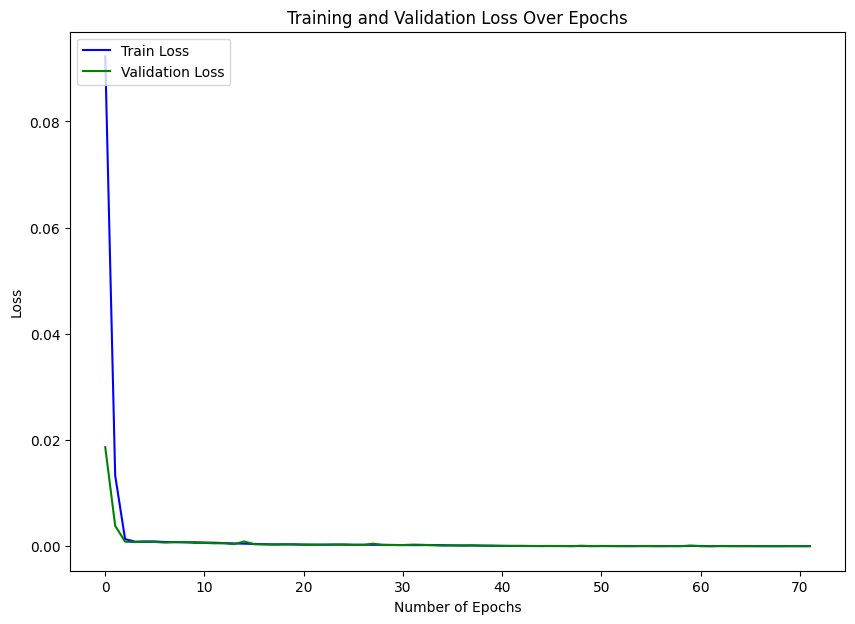

In [41]:
fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(summary_stats.train_loss, 'b', label='Train Loss')
ax.plot(summary_stats.val_loss, 'g', label='Validation Loss')
ax.set_xlabel('Number of Epochs')
ax.set_ylabel('Loss')
ax.set_title('Training and Validation Loss Over Epochs')
ax.legend(loc='upper left')

plt.show()

In [42]:
min_loss, idx = min((loss, idx) for (idx, loss) in enumerate(history.history['val_loss']))
print('Minimum val_loss at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(min_loss))
min_loss = round(min_loss, 4)

Minimum val_loss at epoch 62 = 0.0000


In [43]:
def evaluate_model_test_iter(ten_orig_1, time_pred, inputWidth, std_val, mean_val):
    ten_orig = np.copy(ten_orig_1)

    output_shape = (ten_orig.shape[0], time_pred)

    # For 5D tensors, 
    if len(ten_orig.shape) == 5:
        output_shape = (ten_orig.shape[0], time_pred)
        
    predictions = np.empty(output_shape)

    snap = np.copy(ten_orig[..., -inputWidth:])
    snap = np.transpose(snap, [1, 0])
    snap = snap[None, ...]
    print(f"Input snapshot shape: {snap.shape}")
    
    # Iteratively predict the next time steps
    for i in range(time_pred):
        pred = model.predict(snap, verbose=0)
        pred = np.array(pred)

        if len(pred.shape) == 2:
            pred = pred[:, None, :]

        pred = np.transpose(pred, [1, 0, 2])

        # Apply inverse transformation using std_val and mean_val
        pred_1 = np.copy(pred[0, :, :]) * std_val + mean_val

       
        predictions[..., i] = pred_1

        # Concatenate the new prediction with the previous input
        snap = np.concatenate([snap[:, 1:, :], pred], axis=1)

    del ten_orig, snap, pred, pred_1

    return predictions


t0 = time.time()

time_pred = 100  # Number of time steps to predict
inputWidth = best_hps['seq_len']  

predictions = evaluate_model_test_iter(
    tensor_norm[:, :-100], 
    time_pred=time_pred, 
    inputWidth=inputWidth, 
    std_val=std_val, 
    mean_val=mean_val
)


target_start = int(input("Enter the starting index for targets (e.g., 400): ").strip())

if len(tensorOrig.shape) == 4:
    targets = tensorOrig[:, :, :, target_start:target_start + time_pred]
elif len(tensorOrig.shape) == 5:
    targets = tensorOrig[:, :, :, :, target_start:target_start + time_pred]

t1 = time.time()

# Print results
print(f"Time taken: {t1 - t0} seconds")
print(f"Predictions shape: {predictions.shape}")

Input snapshot shape: (1, 5, 10)


Enter the starting index for targets (e.g., 400):  400


Time taken: 8.016616821289062 seconds
Predictions shape: (10, 100)


In [45]:
targets.shape

(2, 100, 100, 100)

In [47]:
num_modes = len(U_train[0])  
U_pred = np.zeros(shape=(1, num_modes), dtype=object)
for i in range(num_modes - 1):
    U_pred[0, i] = U_train[0, i]

U_pred[0, num_modes - 1] = predictions.T
# Perform the element-wise division with the singular values for the temporal mode
temporal_mode = num_modes - 1  
U_pred[0, temporal_mode] = U_pred[0, temporal_mode] / sv_train[0, temporal_mode][None, :n_train[temporal_mode]]

print(f"Shape of U_pred[0,0]: {U_pred[0,0].shape}")
print(f"Shape of U_pred[0,{temporal_mode}]: {U_pred[0,temporal_mode].shape}")

A_d = hosvd.tprod(S_train, U_pred)
A_d = A_d #+ tensor_train_mean

print(f"Reconstructed tensor shape: {A_d.shape}")

Shape of U_pred[0,0]: (2, 2)
Shape of U_pred[0,3]: (100, 10)
Reconstructed tensor shape: (2, 100, 100, 100)


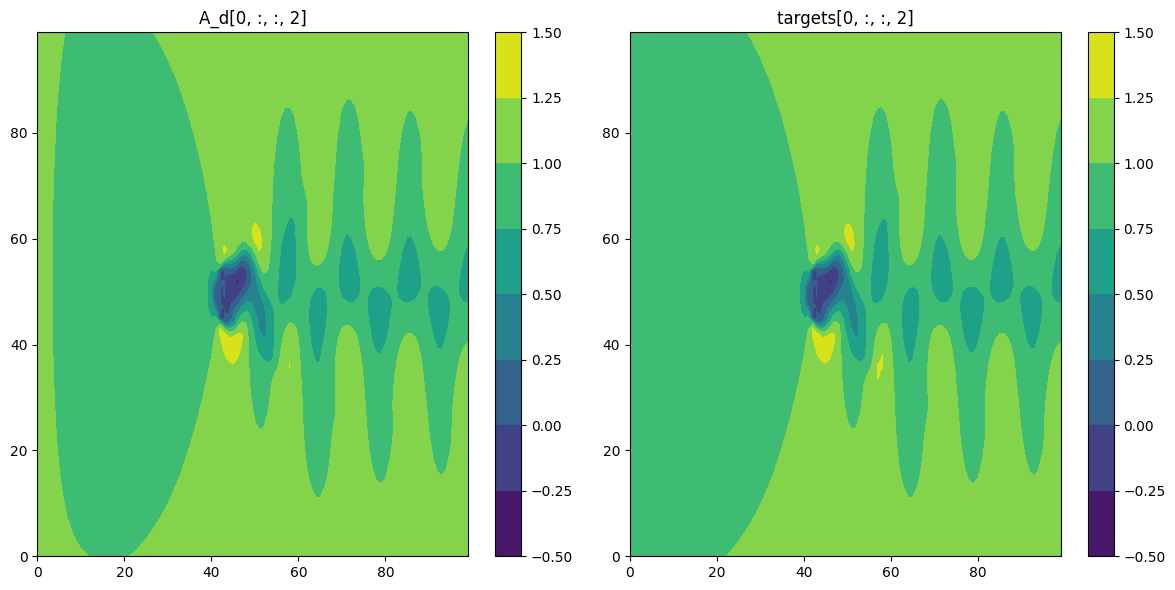

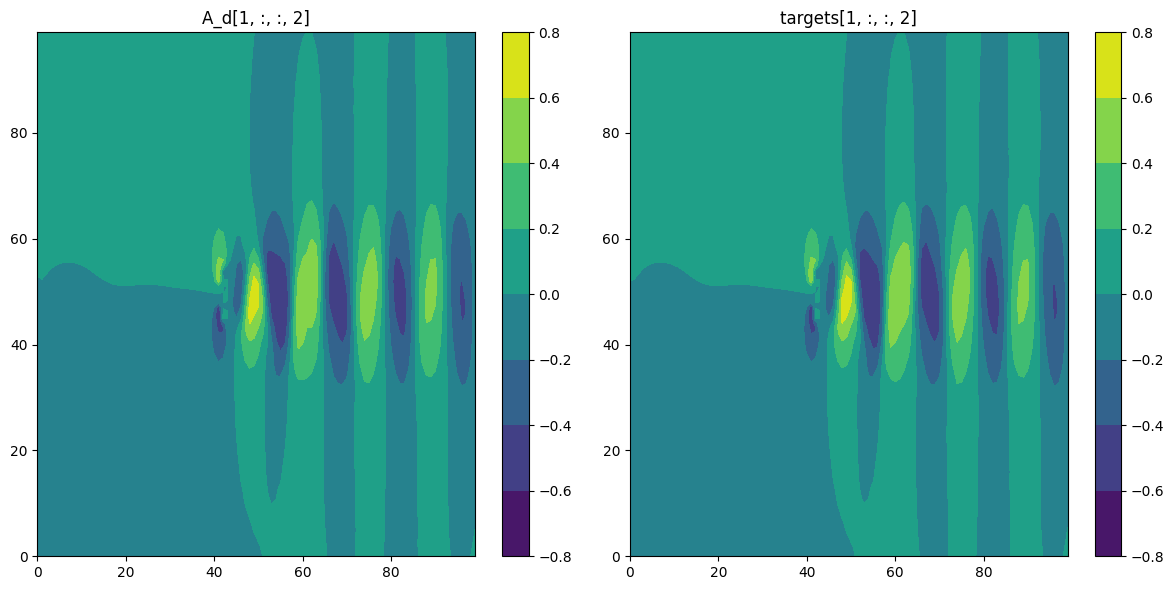

In [48]:
def plot_tensors(A_d, targets, velocity_components, time_index):   
    if A_d.ndim not in [4, 5] or targets.ndim not in [4, 5]:
        raise ValueError("Input tensors must be 4D or 5D.")    
    if A_d.shape != targets.shape:
        raise ValueError("Shape of A_d and targets must match.")
    
    for comp in range(velocity_components):
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))
       
        contour_pred = axs[0].contourf(
            A_d[comp, :, :, 0, time_index] if A_d.ndim == 5 else A_d[comp, :, :, time_index],
            cmap='viridis'
        )
        axs[0].set_title(f'A_d[{comp}, :, :, 0, {time_index}]' if A_d.ndim == 5 else f'A_d[{comp}, :, :, {time_index}]')
        fig.colorbar(contour_pred, ax=axs[0], orientation='vertical')
        
        contour_target = axs[1].contourf(
            targets[comp, :, :, 0, time_index] if targets.ndim == 5 else targets[comp, :, :, time_index],
            cmap='viridis'
        )
        axs[1].set_title(f'targets[{comp}, :, :, 0, {time_index}]' if targets.ndim == 5 else f'targets[{comp}, :, :, {time_index}]')
        fig.colorbar(contour_target, ax=axs[1], orientation='vertical')
        
        plt.tight_layout()        
        plt.show()

time_index = 2 
velocity_components = 2  
plot_tensors(A_d, targets, velocity_components, time_index)